In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cir_sde(n_timesteps, dt, theta_1, theta_2, mu_0=0.0, sigma_0=1.0, sigma_q=1.0, sub_step=10):
    x_T = np.zeros(n_timesteps + 1)
    t_T = np.zeros(n_timesteps + 1)
    
    x_0 = mu_0 + sigma_0 * float(np.random.randn())
    x_T[0] = x_0
    t_T[0] = 0
    
    d_dt = dt / sub_step
    for t in range(1, n_timesteps + 1):
        x_int = x_T[t - 1]
        
        for _ in range(sub_step):
            eps_t = sigma_q * np.sqrt(d_dt) * float(np.random.randn())
            dx_t = -theta_1 * x_int * d_dt + theta_2 * np.sqrt(1 + x_int ** 2) * eps_t
            x_int = x_int + dx_t
        
        x_T[t] = x_int
        t_T[t] = t_T[t - 1] + dt
    
    return x_T, t_T
        

In [3]:
def observation_model(x_T, H=1.0, sigma_r=1.0):
    eps_T = sigma_r * np.random.randn(len(x_T) - 1)
    y_T = H * x_T[1:] + eps_T
    return y_T

In [4]:
def sde_ekf(y_T, dt, theta_1, theta_2, H=1.0, m_0=0.0, sigma_0=1.0, sigma_q=1.0, sigma_r=1.0, sub_step=10):
    m_prev = m_0
    P_prev = sigma_0 ** 2
    
    m_filter = np.zeros(len(y_T))
    P_filter = np.zeros(len(y_T))
    
    d_dt = dt / sub_step
    for t in range(len(y_T)):
        
        # Prediction Step: Solve by Numerical Integration
        m_int = m_prev
        P_int = P_prev
        
        for _ in range(sub_step):
            increment_m = -theta_1 * m_int 
            increment_P = -2 * theta_1 * P_int + (1 + m_int ** 2) * ((theta_2 * sigma_q) ** 2)
            m_int = m_int + increment_m * d_dt
            P_int = P_int + increment_P * d_dt
        
        # EKF Update Step
        v = y_T[t] - H * m_int
        S = H * H * P_int + sigma_r ** 2
        K = P_int * H / S
        
        m_prev = m_int + K * v
        P_prev = P_int - K * K * S
        
        m_filter[t] = m_prev
        P_filter[t] = P_prev
    
    return m_filter, P_filter

In [5]:
def sde_ckf(y_T, dt, theta_1, theta_2, H=1.0, m_0=0.0, sigma_0=1.0, sigma_q=1.0, sigma_r=1.0, sub_step=10):
    m_prev = m_0
    P_prev = sigma_0 ** 2
    
    m_filter = np.zeros(len(y_T))
    P_filter = np.zeros(len(y_T))
    
    d_dt = dt / sub_step
    for t in range(len(y_T)):
        
        # Prediction Step: Solve by Numerical Integration
        m_int = m_prev
        P_int = P_prev
        
        for _ in range(sub_step):
            m1 = m_int + np.sqrt(P_int)
            m2 = m_int - np.sqrt(P_int)
            
            increment_m = -0.5 * theta_1 * (m1 + m2)
            increment_P = -theta_1 * np.sqrt(P_int) * (m1 - m2) + 0.5 * ((sigma_q * theta_2) ** 2) * (2 + m1 ** 2 + m2 ** 2)
            
            m_int = m_int + increment_m * d_dt
            P_int = P_int + increment_P * d_dt
        
        # Update Step: Same as Regular Kalman Filter
        v = y_T[t] - H * m_int
        S = H * H * P_int + sigma_r ** 2
        K = P_int * H / S
        
        m_prev = m_int + K * v
        P_prev = P_int - K * K * S
        
        m_filter[t] = m_prev
        P_filter[t] = P_prev
    
    return m_filter, P_filter,

In [6]:
n_timesteps = 1000
dt = 0.01
theta_1 = 2
theta_2 = 3
mu_0 = 0.0
sigma_0 = 1.0
sigma_q = 0.2
sub_step = 10
sigma_r = 1.0
H = 1.0

In [7]:
x_T, t_T = cir_sde(n_timesteps, dt, theta_1, theta_2, mu_0, sigma_0, sigma_q, sub_step)
y_T = observation_model(x_T, H, sigma_r)

In [8]:
m_ekf, P_ekf = sde_ekf(y_T, dt, theta_1, theta_2, H, mu_0, sigma_0, sigma_q, sigma_r, sub_step)
m_ckf, P_ckf = sde_ckf(y_T, dt, theta_1, theta_2, H, mu_0, sigma_0, sigma_q, sigma_r, sub_step)

rms_baseline = np.mean((x_T[1:] - y_T) ** 2)
rms_ekf = np.mean((x_T[1:] - m_ekf) ** 2)
rms_ckf = np.mean((x_T[1:] - m_ckf) ** 2)

print('RMS of Baseline : {}'.format(rms_baseline))
print('RMS of EKF: {}'.format(rms_ekf))
print('RMS of CKF: {}'.format(rms_ckf))

RMS of Baseline : 1.0219660462946598
RMS of EKF: 0.0535165699964016
RMS of CKF: 0.05352678512211112


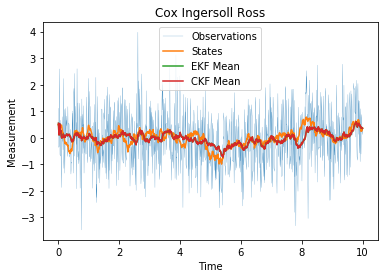

In [9]:
plt.plot(t_T[1:], y_T, linewidth=0.2, label='Observations')
plt.plot(t_T, x_T, label='States')
plt.plot(t_T[1:], m_ekf, label='EKF Mean')
plt.plot(t_T[1:], m_ckf, label='CKF Mean')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Cox Ingersoll Ross')
plt.legend()

In [12]:
import tqdm
n_rep = 10

rms_b = 0.0
rms_e = 0.0
rms_c = 0.0
for _ in tqdm.tqdm(range(n_rep)):
    x_T, t_T = cir_sde(n_timesteps, dt, theta_1, theta_2, mu_0, sigma_0, sigma_q, sub_step)
    y_T = observation_model(x_T, H, sigma_r)
    m_ekf, P_ekf = sde_ekf(y_T, dt, theta_1, theta_2, H, mu_0, sigma_0, sigma_q, sigma_r, sub_step)
    m_ckf, P_ckf = sde_ckf(y_T, dt, theta_1, theta_2, H, mu_0, sigma_0, sigma_q, sigma_r, sub_step)
    rms_b += np.mean((x_T[1:] - y_T) ** 2)
    rms_e += np.mean((x_T[1:] - m_ekf) ** 2)
    rms_c += np.mean((x_T[1:] - m_ckf) ** 2)

print(rms_b / n_rep, rms_e / n_rep, rms_c / n_rep)

100%|██████████| 10/10 [00:00<00:00, 10.38it/s]

0.9863546461084305 0.04862245223156896 0.04855045611828464
